## Imports and dataset

In [1]:
from src.models.optimized_bnn import BayesianNN, DBNN
from src.utils2 import plot_ppds

from src.attacks.distr_attacks_bnn_jax import fgsm_attack, mlmc_attack, kl_to_appd

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed
from tqdm import tqdm 

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/weights/3bnn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/weights/3bnn')

#### appd = N(2mu, 2var)

In [8]:
# Attack example
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.001, n_iter=1000)

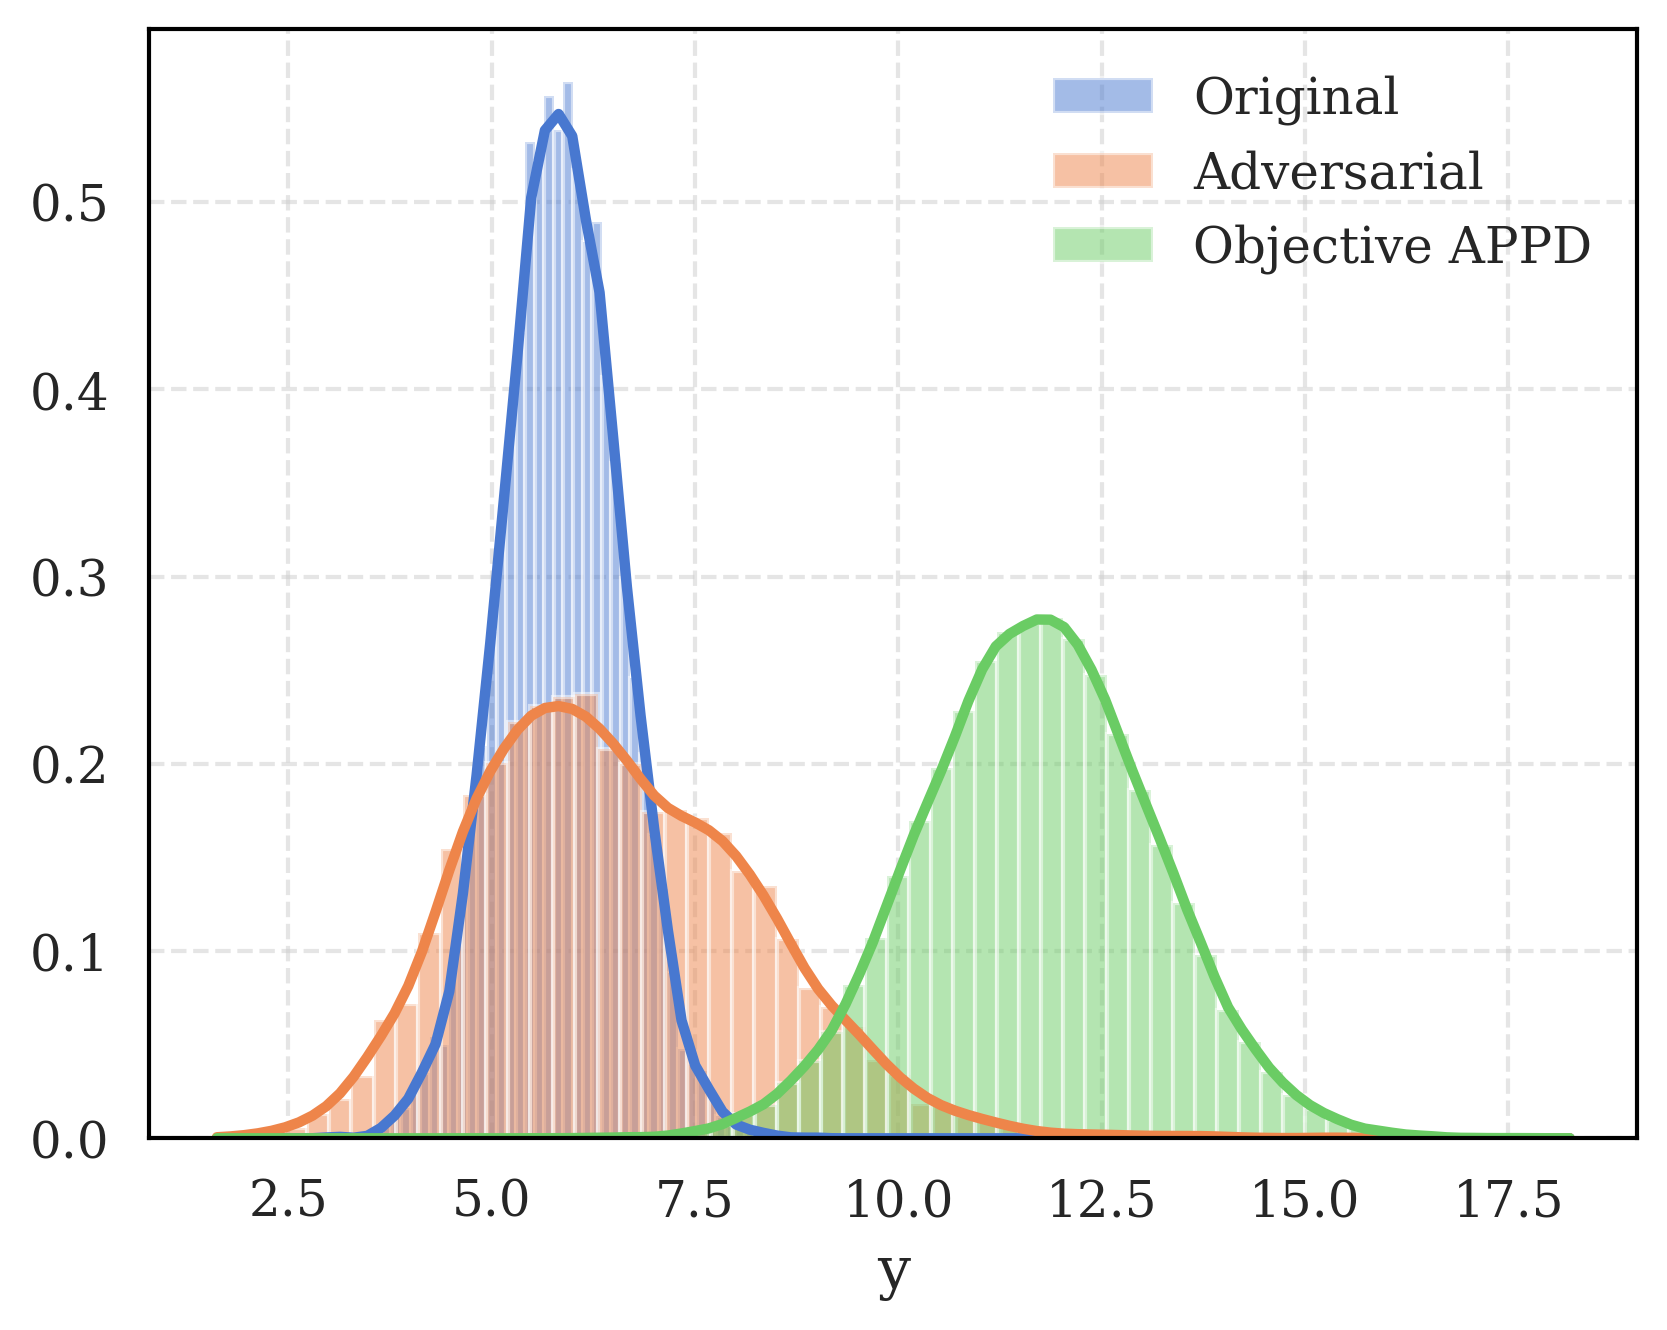

In [9]:
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), appd)

In [10]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, 2 * mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fgsm = kl_to_appd(mu_fgsm, sigma2_fgsm, 2 * mu, 4 * std ** 2).item()
    return kl, kl_fgsm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 10)
kl_alls = []

for _ in range(3):
    print(_)
    # Use joblib to parallelize the computation of KL divergences
    #kl_values = Parallel(n_jobs=n_jobs)(delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons)
    kl_values = []
    for epsilon in epsilons:
        kl_values.append(compute_kl_divergence(epsilon))
    kl_alls.append(kl_values)

kl_mlmc_1000 = np.array(kl_alls)[:, :, 0]
kl_fsgm_1000 = np.array(kl_alls)[:, :, 1]


0


KeyboardInterrupt: 

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_18135/3803497156.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_18135/3803497156.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


ValueError: Axis limits cannot be NaN or Inf

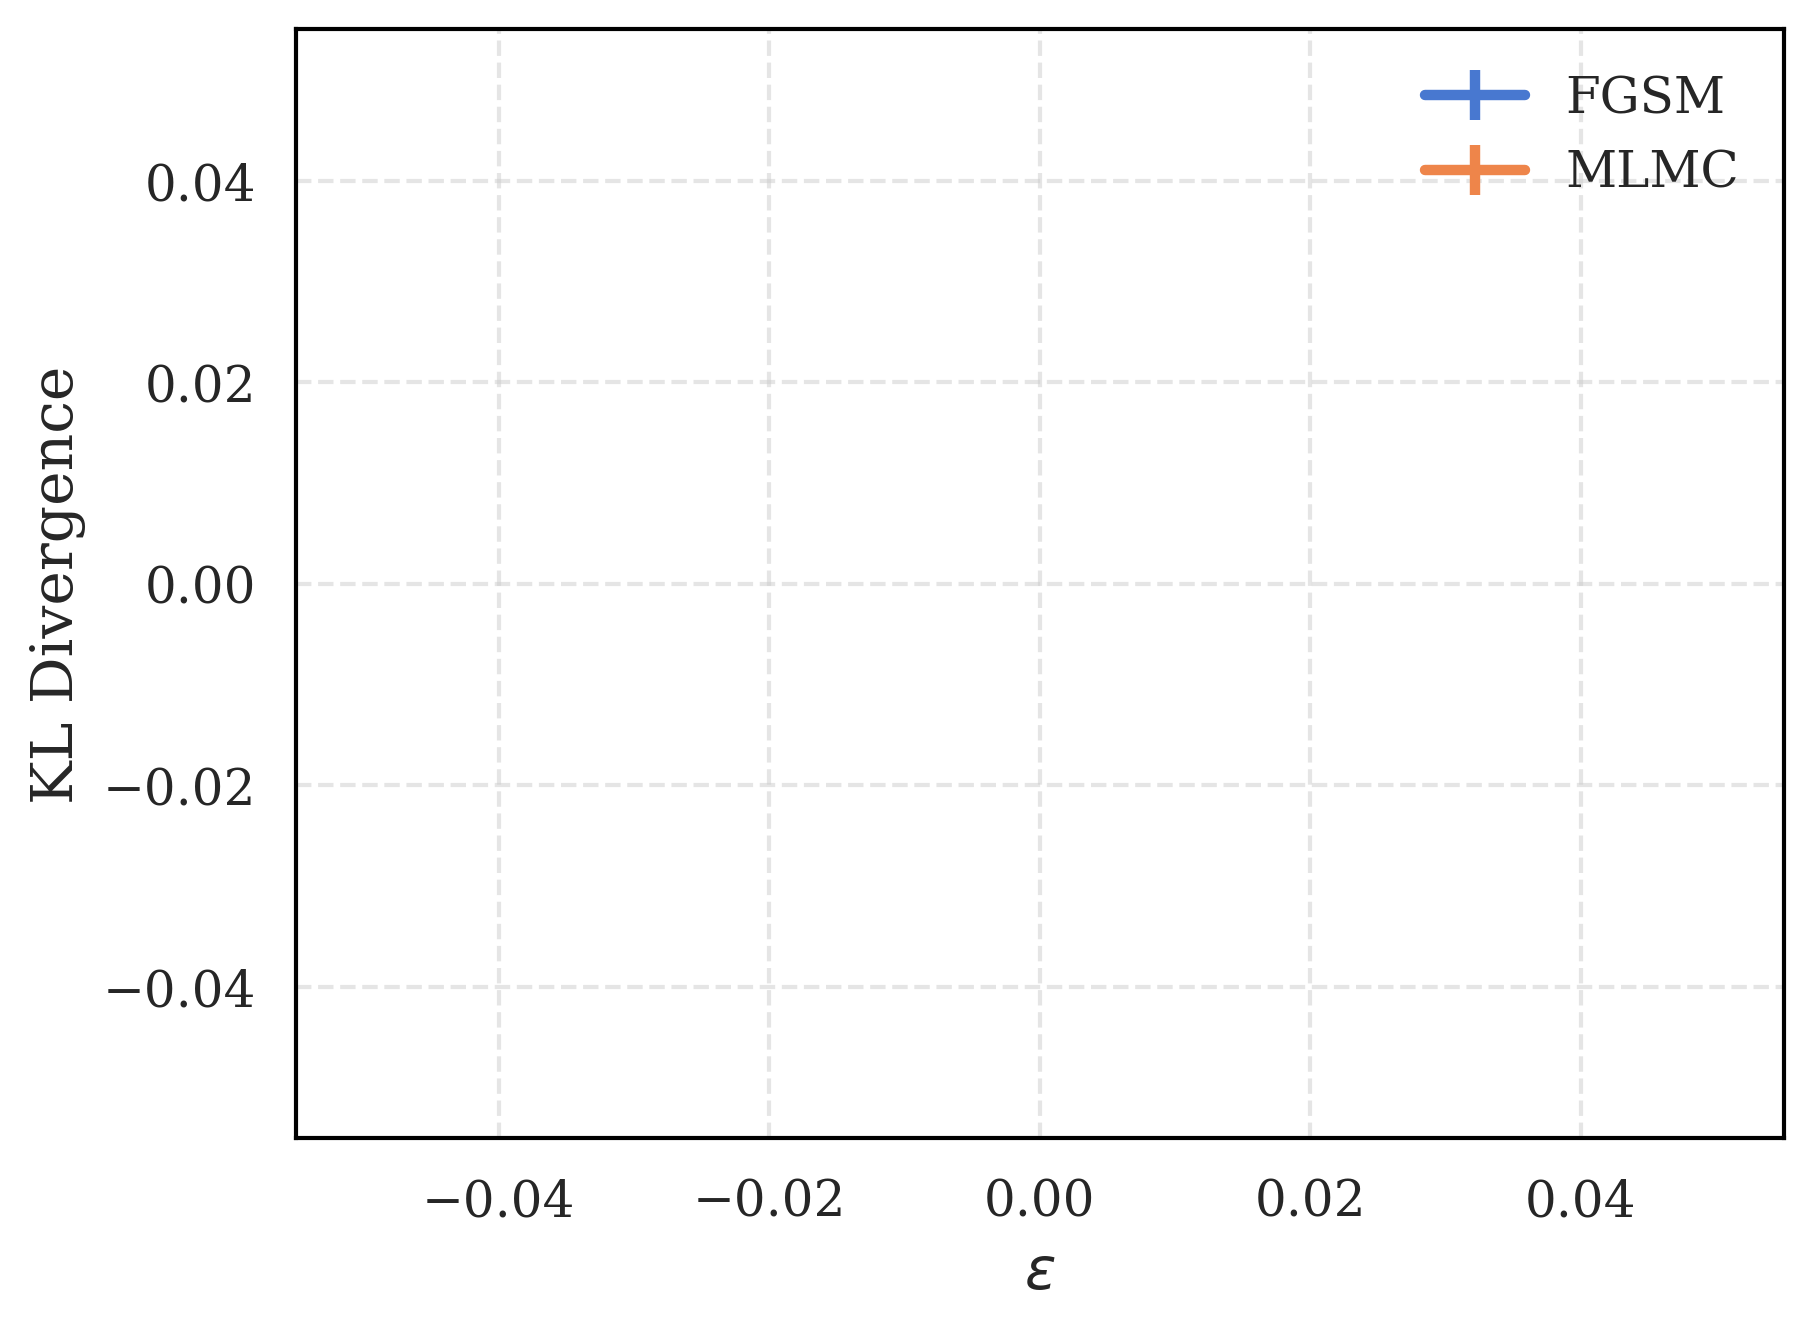

In [ ]:
# error bars as std
plt.errorbar(epsilons, np.mean(kl_fsgm_1000, axis=0), yerr=2*np.std(kl_fsgm_1000, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc_1000, axis=0), yerr=2*np.std(kl_mlmc_1000, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc_1000) + 0.1)

In [ ]:
#plt.errorbar(epsilons, np.mean(kl_fsgm_1000, axis=0), yerr=2*np.std(kl_fsgm_1000, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc_1000, axis=0), yerr=2*np.std(kl_mlmc_1000, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc_1000) + 0.1)

#### appd = N(mu, 2var)

In [ ]:
# Attack example
x = X_test[17,:].copy()
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.normal.Normal(mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.001, n_iter=1000)
plot_ppds(model, x, x_adv_distr, appd)

#### appd = N(3 + mu, 2var)

In [ ]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy()
x = jnp.array(x)
sigma2 = model.sample_posterior_distribution(1000)['sigma2'].mean()
mu = model.sample_predictive_distribution(x, 1000).mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = numpyro.distributions.normal.Normal(3 + mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=2*epsilon, R=10, lr=0.001, n_iter=1000)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, 3 + mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fsgm = kl_to_appd(mu_fgsm, sigma2_fgsm, 3 + mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

## Entropic Tilting for APPD

We want to define de APPD as a tilted version of the PPD with density given by
$$f(y) = p(y) \exp(τ*s(y)−c(τ )), $$
where p(y) is the PPD, s(y) is the set of objective functions, τ is the tilt parameter, and c(τ ) is the log-normalizer.

The objective function is the KL divergence between the APPD and the PPD and is given by
$$φ(τ ) = \int (s(y)−s)\exp(τ*s(y))p(y)dy,$$
with s the desired values of the objective function.

We want to solve φ(τ )=0 for τ, and then sample from the APPD with importance sampling.

In [8]:
class PPD: 
    def __init__(self, model, x):
        self.model = model
        self.x = x

    def sample(self, num_samples=1):
        return self.model.sample_predictive_distribution(self.x, num_samples)

In [9]:
class TiltedPPD:
    """
    Tilted Posterior Predictive Distribution, class that implements the solution to the optimization problem
    with Newton-Raphson and the sampling from the tilted PPD. 
    """
    def __init__(self, ppd, functions, values):
        self.ppd = ppd
        self.functions = functions
        self.values = values
        self.tau = None

    def solve_optimization(self, num_samples=1000, learning_rate=0.01, tol=1e-4, max_iter=1000):
        """
        Solve the optimization problem using Stochastic Gradient Descent (SGD).
        """
        tau = jnp.ones(len(self.functions))
        integral_values = []

        def objective(tau):
            ys = self.ppd.sample(num_samples)
            func_values = jnp.array([func(ys) for func in self.functions]).reshape(-1, num_samples)
            weights = jnp.exp(tau @ func_values)
            weights /= jnp.sum(weights)
            integral = func_values @ weights
            diff = (integral - self.values) ** 2
            return diff @ diff

        grad_objective = jax.grad(objective)

        for _ in range(max_iter):
            gradient = grad_objective(tau)
            tau -= learning_rate * gradient / jnp.linalg.norm(gradient)
            val = objective(tau)
            integral_values.append(val)
            if jnp.isnan(tau).any():
                raise ValueError('Optimization problem diverged.')

            if val < tol:
                break
        
        self.tau = tau
        return tau, integral_values
    
    
    def sample(self, rng, num_samples=1, mult=100):
        """
        Sample from the tilted PPD.
        """
        if self.tau is None:
            print('Optimization problem has not been solved yet, solving...')
            self.solve_optimization()
            print('Optimization problem solved.')
        ppd_samples = self.ppd.sample(mult * num_samples)
        func_values = jnp.array([func(ppd_samples) for func in self.functions]).reshape(-1, mult * num_samples)
        sample_weights = jnp.exp(self.tau @ func_values)
        sample_weights /= jnp.sum(sample_weights)
        resampled_indices = jax.random.choice(rng, jnp.arange(mult * num_samples), shape=(num_samples,), p=sample_weights)
        return ppd_samples[resampled_indices]

In [10]:
class AdjustedPPD: 
    """
    Adjusted Posterior Predictive Distribution, class that implements a PPD with the same shape
    as the original PPD but with different mean and variance. 
    """
    def __init__(self, ppd, mean, variance):
        self.ppd = ppd
        self.mean = mean
        self.variance = variance

    def sample(self, rng, num_samples=1):
        samples = self.ppd.sample(num_samples)
        return (samples - samples.mean()) * jnp.sqrt(self.variance / samples.var()) + self.mean

[3.6199975]
Objective mean: 7.862686
Objective variance: 0.76803875
Tilted mean: 7.9890504
Tilted variance: 0.57528436


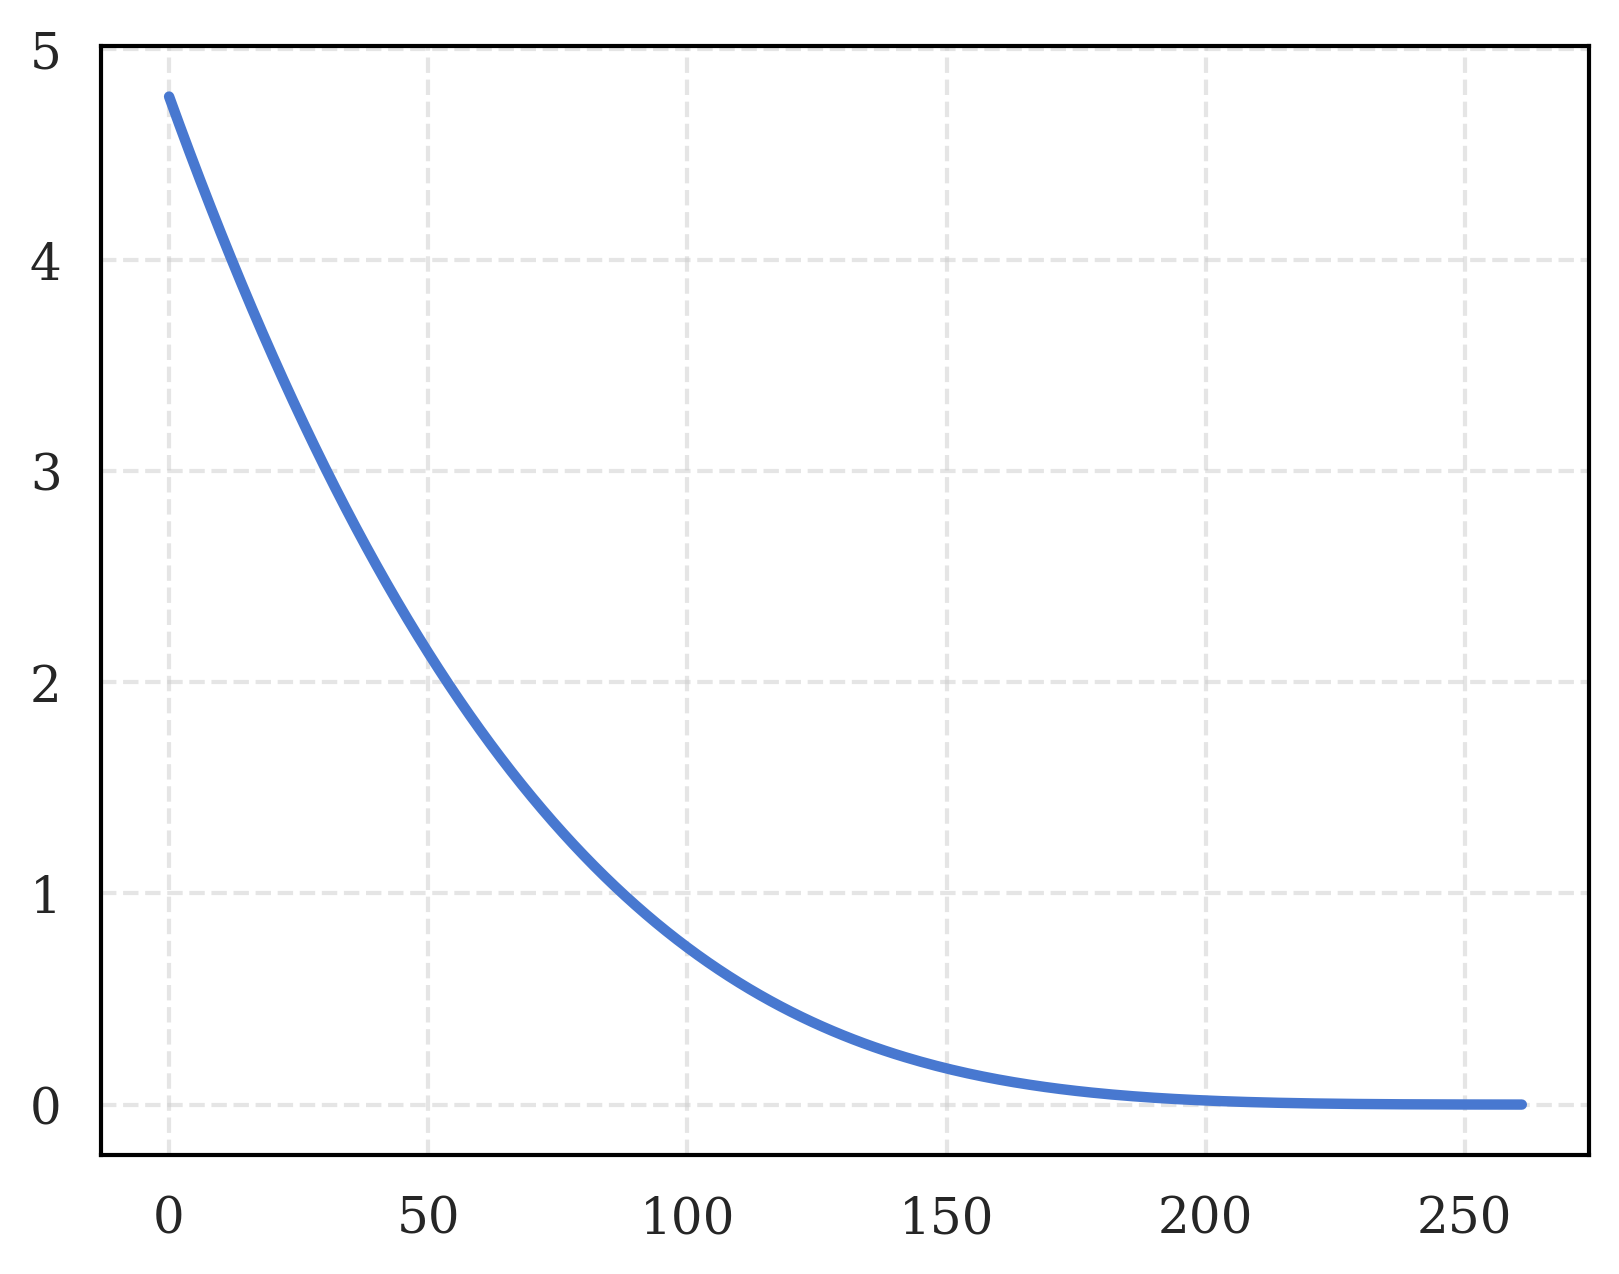

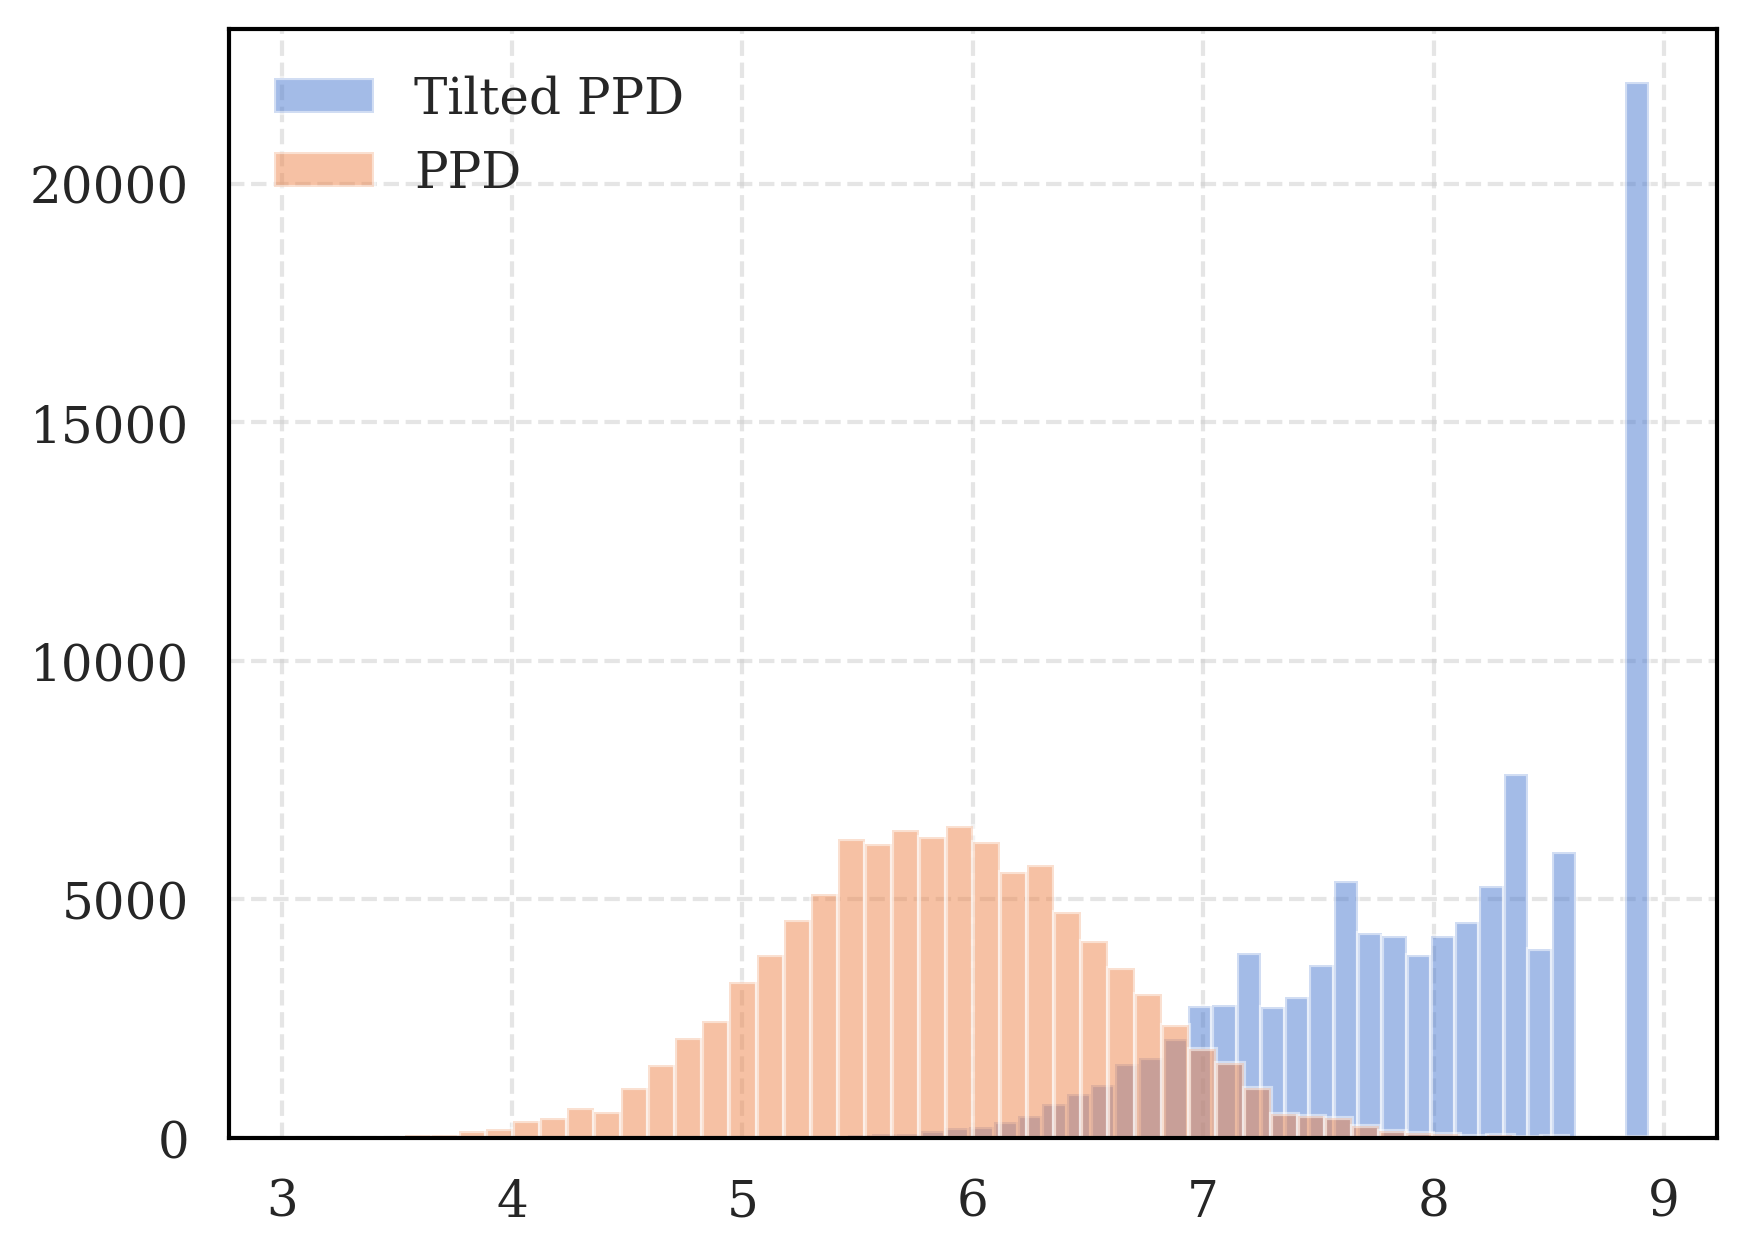

In [11]:
# Attack example
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
ppd = PPD(model, x)
num_samples=100000
samples = ppd.sample(num_samples)

functions = [lambda y: y]#, lambda y: y ** 2]
values = jnp.array([2 + samples.mean()])#, 2 * samples.var() + (2 + samples.mean()) ** 2])
tilted_ppd = TiltedPPD(ppd, functions, values)

tau, int_values = tilted_ppd.solve_optimization(num_samples=1000, max_iter=1000, learning_rate=1e-2)
print(tau)

plt.figure()
plt.plot(int_values)

tilted_samples = tilted_ppd.sample(jax.random.PRNGKey(42), num_samples)
print('Objective mean:', values[0])
print('Objective variance:', 1.5 * samples.var())
print('Tilted mean:', tilted_samples.mean())
print('Tilted variance:', tilted_samples.var())

plt.figure()
plt.hist(tilted_samples, bins=50, alpha=0.5, label='Tilted PPD')
plt.hist(samples, bins=50, alpha=0.5, label='PPD')
plt.legend()
plt.show()

In [12]:
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=tilted_ppd, epsilon=2, R=10, lr=0.001, n_iter=1000)

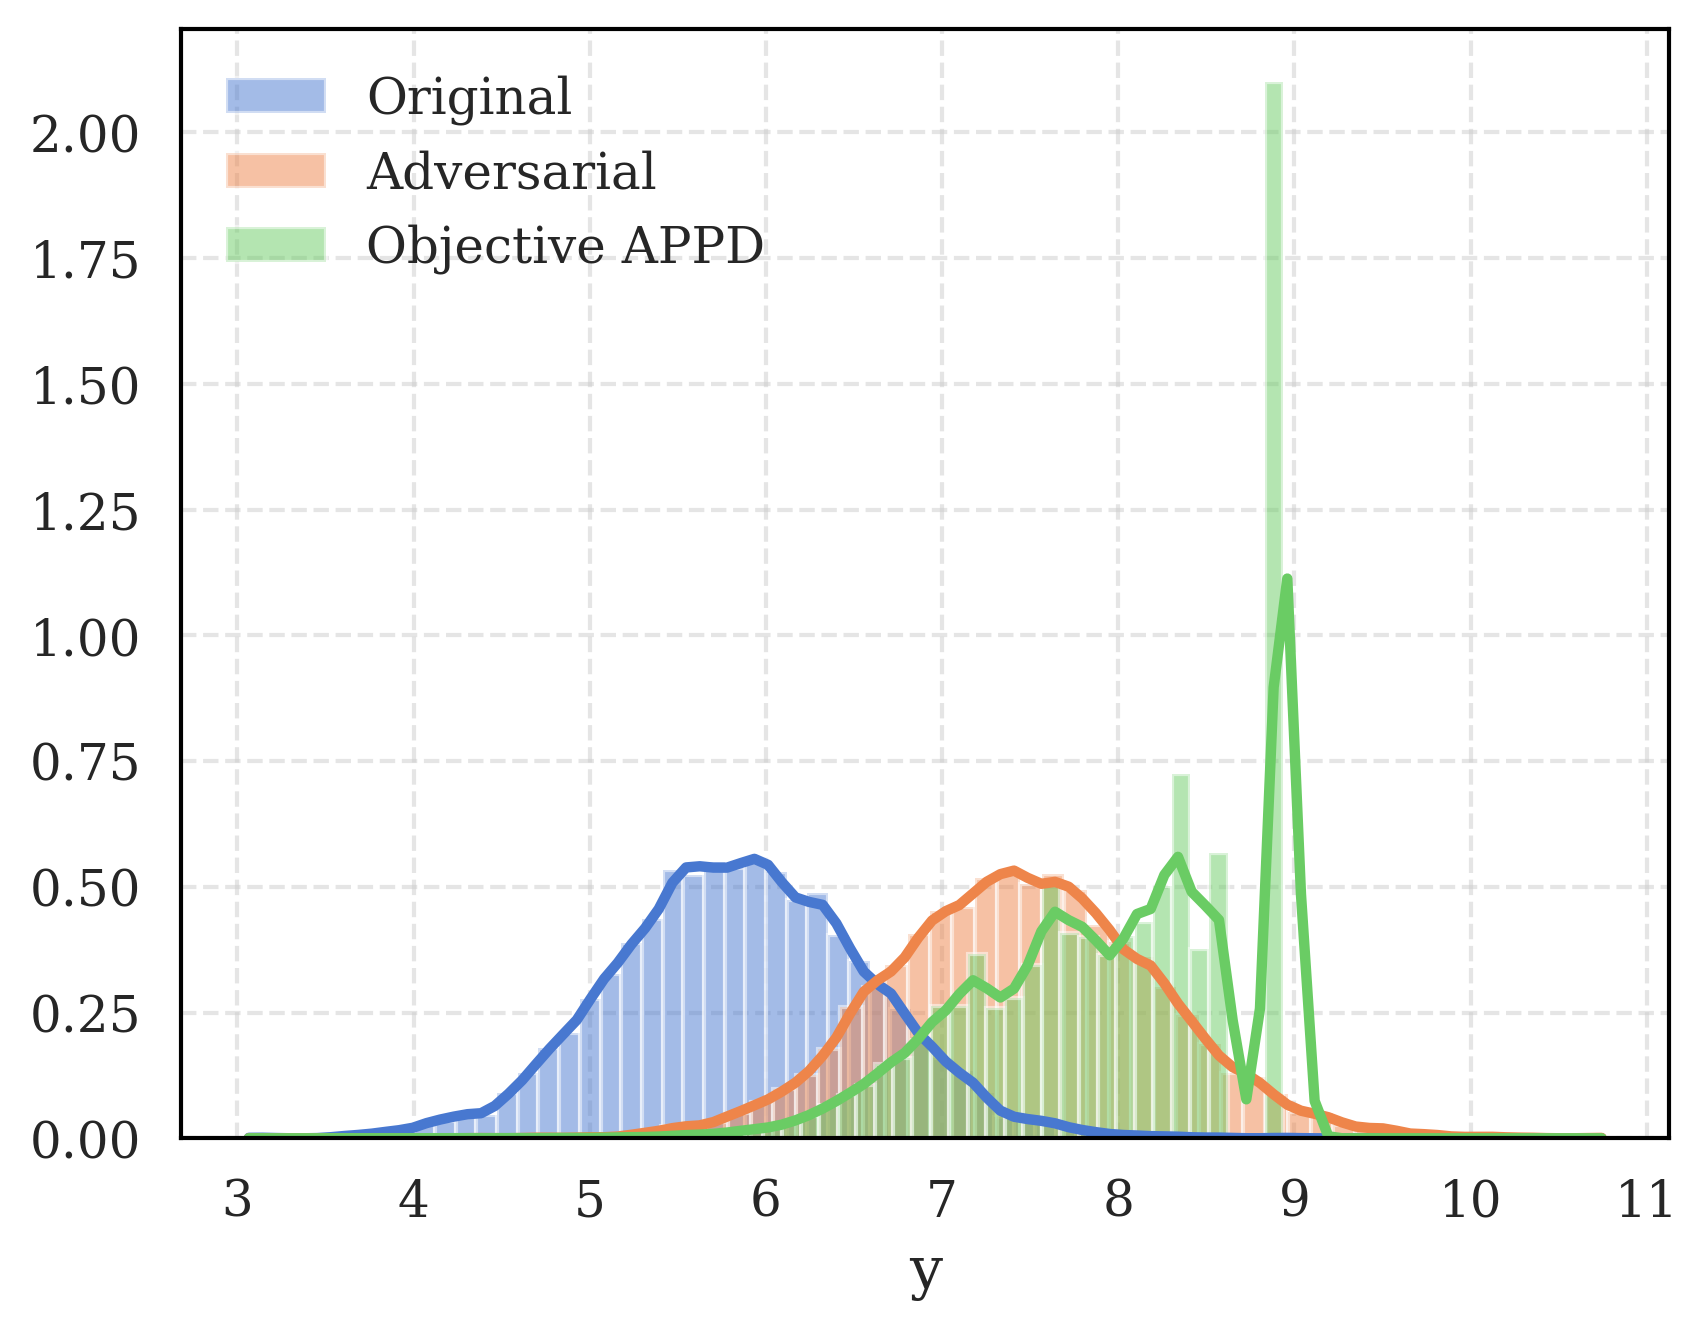

In [13]:
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), tilted_ppd)

In [100]:
# Attack example
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
ppd = PPD(model, x)
samples = ppd.sample(1000)
adjusted_ppd = AdjustedPPD(ppd, 2 * samples.mean(), 2 * samples.var())

In [102]:
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=tilted_ppd, epsilon=2, R=10, lr=0.001, n_iter=1000)
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), adjusted_ppd)

: 

In [95]:
x_adv_values

[array([[0.16444711, 0.0383052 , 0.19974913, 0.00714547, 0.08497881,
         0.07418057, 0.28410143, 0.08634547, 0.48292476, 0.2684645 ,
         0.2910677 ]], dtype=float32),
 array([[0.16540283, 0.0373745 , 0.20062166, 0.00807127, 0.08404412,
         0.07509044, 0.28448364, 0.08541898, 0.48387063, 0.2693975 ,
         0.29200053]], dtype=float32),
 array([[0.16637838, 0.03642033, 0.20151949, 0.00902071, 0.08308668,
         0.0760223 , 0.28449345, 0.08446878, 0.48483768, 0.27035394,
         0.29295638]], dtype=float32),
 array([[0.16736628, 0.03544684, 0.2024519 , 0.00999091, 0.08211083,
         0.07697866, 0.2843565 , 0.08349799, 0.4858201 , 0.27132913,
         0.29393095]], dtype=float32),
 array([[0.16836125, 0.03446376, 0.2033992 , 0.01097166, 0.08112497,
         0.07794724, 0.284211  , 0.08251666, 0.48681122, 0.2723137 ,
         0.2949146 ]], dtype=float32),
 array([[0.16936144, 0.03347631, 0.2043657 , 0.01195593, 0.08012832,
         0.07889774, 0.28374866, 0.08152978, 0